### Table of Contents
1. [Importing data](#importing) 
2. [Transforming categorical variables](#onehot)
3. [Transforming outliers](#outliers)
4. [Creating cyclical time features](#cyclical)
5. [Setting up the validation framework](#validation)
6. [Selecting features](#features)
7. [Scaling Numerical Features](#numerical)
8. [Choosing the model](#model)
9. [Fitting model](#fitting)
10. [Baseline model](#baseline)
11. [Results and findings](#results)

### Importing data <a class="anchor" id="importing"></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
# setting the option to display maximum rows and columns
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)

#displaying numbers in non-scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

# ignoring future warnings that might arise from pandas updates
warnings.simplefilter(action='ignore', category=FutureWarning)

# setting global float format to include commas
pd.options.display.float_format = '{:,.0f}'.format

In [3]:
#importing datasets
df = pd.read_csv("../data/train_final.csv", low_memory=False)
df_test = pd.read_csv("../data/test_final.csv", low_memory=False)

### Transforming categorical variables <a class="anchor" id="onehot"></a>


Transforming categorical variables is a key step in preparing data for machine learning models, as most models require numerical input. Pandas' get_dummies and label encoding are common techniques used to achieve this. get_dummies converts each category into separate binary columns (0 or 1) for each unique value in the categorical variable, which is useful when there is no ordinal relationship between categories. 

The model also keep numerical values unchanged.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008280 entries, 0 to 3008279
Data columns (total 14 columns):
 #   Column     Dtype  
---  ------     -----  
 0   index      int64  
 1   date       object 
 2   store_nbr  int64  
 3   products   object 
 4   sales      float64
 5   promo      int64  
 6   city       object 
 7   oil_price  float64
 8   holiday    bool   
 9   events     bool   
 10  year       int64  
 11  month      int64  
 12  day        int64  
 13  weekday    int64  
dtypes: bool(2), float64(2), int64(7), object(3)
memory usage: 281.2+ MB


In [5]:
df = df.drop(columns=['date', 'index'])
df.head()

,store_nbr,products,sales,promo,city,oil_price,holiday,events,year,month,day,weekday
0,1,automotive,0,0,quito,93,True,False,2013,1,1,1
1,1,baby_care,0,0,quito,93,True,False,2013,1,1,1
2,1,beauty,0,0,quito,93,True,False,2013,1,1,1
3,1,beverages,0,0,quito,93,True,False,2013,1,1,1
4,1,books,0,0,quito,93,True,False,2013,1,1,1


In [6]:
df = pd.get_dummies(df, dtype=int, sparse=True)

In [7]:
#verifying results
df.head()

,store_nbr,sales,promo,oil_price,holiday,events,year,month,day,weekday,products_automotive,products_baby_care,products_beauty,products_beverages,products_books,products_bread/bakery,products_celebration,products_cleaning,products_dairy,products_deli,products_eggs,products_frozen_foods,products_grocery_i,products_grocery_ii,products_hardware,products_home_and_kitchen_i,products_home_and_kitchen_ii,products_home_appliances,products_home_care,products_ladieswear,products_lawn_and_garden,products_lingerie,"products_liquor,wine,beer",products_magazines,products_meats,products_personal_care,products_pet_supplies,products_players_and_electronics,products_poultry,products_prepared_foods,products_produce,products_school_and_office_supplies,products_seafood,city_ambato,city_babahoyo,city_cayambe,city_cuenca,city_daule,city_el_carmen,city_esmeraldas,city_guaranda,city_guayaquil,city_ibarra,city_latacunga,city_libertad,city_loja,city_machala,city_manta,city_playas,city_puyo,city_quevedo,city_quito,city_riobamba,city_salinas,city_santo_domingo
0,1,0,0,93,True,False,2013,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,0,0,93,True,False,2013,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,0,0,93,True,False,2013,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,93,True,False,2013,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,93,True,False,2013,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      28512 non-null  int64  
 1   date       28512 non-null  object 
 2   store_nbr  28512 non-null  int64  
 3   products   28512 non-null  object 
 4   sales      0 non-null      float64
 5   promo      28512 non-null  int64  
 6   city       28512 non-null  object 
 7   oil_price  28512 non-null  float64
 8   holiday    28512 non-null  bool   
 9   events     28512 non-null  bool   
 10  year       28512 non-null  int64  
 11  month      28512 non-null  int64  
 12  day        28512 non-null  int64  
 13  weekday    28512 non-null  int64  
dtypes: bool(2), float64(2), int64(7), object(3)
memory usage: 2.7+ MB


In [9]:
df_test = df_test.drop(['date', 'index', 'sales'], axis=1)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   store_nbr  28512 non-null  int64  
 1   products   28512 non-null  object 
 2   promo      28512 non-null  int64  
 3   city       28512 non-null  object 
 4   oil_price  28512 non-null  float64
 5   holiday    28512 non-null  bool   
 6   events     28512 non-null  bool   
 7   year       28512 non-null  int64  
 8   month      28512 non-null  int64  
 9   day        28512 non-null  int64  
 10  weekday    28512 non-null  int64  
dtypes: bool(2), float64(1), int64(6), object(2)
memory usage: 2.0+ MB


In [11]:
df_test = pd.get_dummies(df_test, dtype=int, sparse=True)

In [12]:
df_test.head()

,store_nbr,promo,oil_price,holiday,events,year,month,day,weekday,products_automotive,products_baby_care,products_beauty,products_beverages,products_books,products_bread/bakery,products_celebration,products_cleaning,products_dairy,products_deli,products_eggs,products_frozen_foods,products_grocery_i,products_grocery_ii,products_hardware,products_home_and_kitchen_i,products_home_and_kitchen_ii,products_home_appliances,products_home_care,products_ladieswear,products_lawn_and_garden,products_lingerie,"products_liquor,wine,beer",products_magazines,products_meats,products_personal_care,products_pet_supplies,products_players_and_electronics,products_poultry,products_prepared_foods,products_produce,products_school_and_office_supplies,products_seafood,city_ambato,city_babahoyo,city_cayambe,city_cuenca,city_daule,city_el_carmen,city_esmeraldas,city_guaranda,city_guayaquil,city_ibarra,city_latacunga,city_libertad,city_loja,city_machala,city_manta,city_playas,city_puyo,city_quevedo,city_quito,city_riobamba,city_salinas,city_santo_domingo
0,1,0,47,False,False,2017,8,16,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,0,47,False,False,2017,8,16,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,2,47,False,False,2017,8,16,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,20,47,False,False,2017,8,16,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,47,False,False,2017,8,16,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Transforming outliers <a id="outliers"></a> 

Let's check for outliers in 'sales' column. 

<Axes: xlabel='sales', ylabel='Count'>

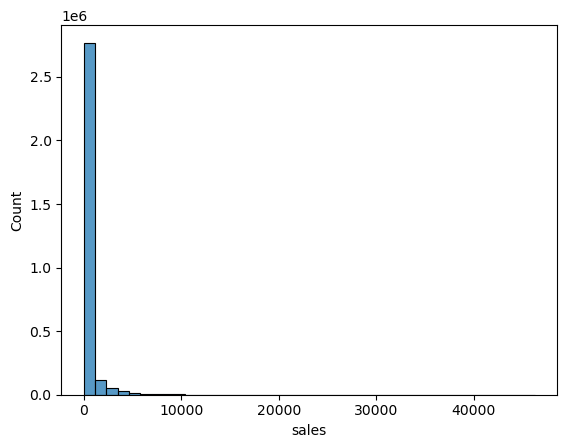

In [13]:
sns.histplot(df.sales, bins = 40)

In [14]:
# checking if zero or negative values are present
df.sales.describe().loc[['min', 'max']] 

min        0
max   46,271
Name: sales, dtype: float64

As we can see there are zero values present in our 'sales' column, thus we would not be able to apply logarithmic transformation log(x) as it is not defined for zero or negative values. 

Instead, we can use the log1p(x) transformation, which applies the logarithm to x + 1. This method handles zero values effectively, as log1p(0) is defined and equals 0, allowing us to transform the data without issues caused by zeros or small values.

Let's compare their visual results

In [15]:
transformed_sales = np.log1p(df['sales']) 

In [16]:
transformed_sales.describe().loc[['min', 'max']] 

min    0
max   11
Name: sales, dtype: float64

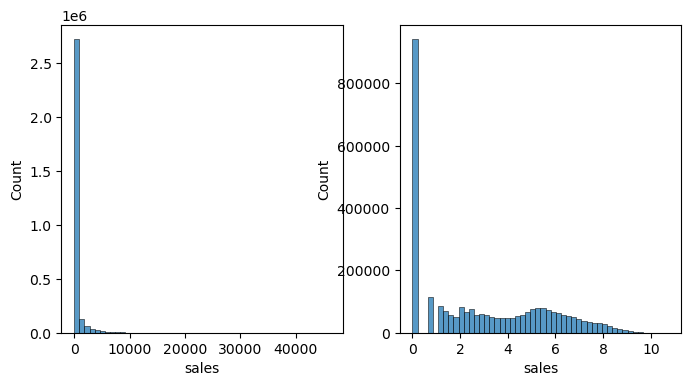

In [17]:
plt.figure(figsize = [8,4])

plt.subplot(1, 2, 1)
sns.histplot(df.sales, bins = 50)

plt.subplot(1, 2, 2)
sns.histplot(transformed_sales, bins = 50)

plt.show()

From the histogram on the left, for 'sales' value, which shows the original distribution, it appears to be highly skewed to the right (positive skewness). Most of the data points are concentrated around the lower values, with a long tail extending towards the higher values (indicating some high sales values).

On the right, after applying the log1p transformation, the distribution appears to have been compressed and normalized to some extent. The transformation has reduced the impact of extreme values (the long tail) by compressing the larger values, bringing the data into a more manageable range. This often makes the data more suitable for machine learning models, as it can improve performance by addressing skewness and reducing the variance. However, we should keep this detail in mind when selecting a model.

In [18]:
df['sales'] = transformed_sales
#verifying results
df.head()

,store_nbr,sales,promo,oil_price,holiday,events,year,month,day,weekday,products_automotive,products_baby_care,products_beauty,products_beverages,products_books,products_bread/bakery,products_celebration,products_cleaning,products_dairy,products_deli,products_eggs,products_frozen_foods,products_grocery_i,products_grocery_ii,products_hardware,products_home_and_kitchen_i,products_home_and_kitchen_ii,products_home_appliances,products_home_care,products_ladieswear,products_lawn_and_garden,products_lingerie,"products_liquor,wine,beer",products_magazines,products_meats,products_personal_care,products_pet_supplies,products_players_and_electronics,products_poultry,products_prepared_foods,products_produce,products_school_and_office_supplies,products_seafood,city_ambato,city_babahoyo,city_cayambe,city_cuenca,city_daule,city_el_carmen,city_esmeraldas,city_guaranda,city_guayaquil,city_ibarra,city_latacunga,city_libertad,city_loja,city_machala,city_manta,city_playas,city_puyo,city_quevedo,city_quito,city_riobamba,city_salinas,city_santo_domingo
0,1,0,0,93,True,False,2013,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,0,0,93,True,False,2013,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,0,0,93,True,False,2013,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,93,True,False,2013,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,93,True,False,2013,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Now should follow the same process for values in 'promo' column. 

<Axes: xlabel='promo', ylabel='Count'>

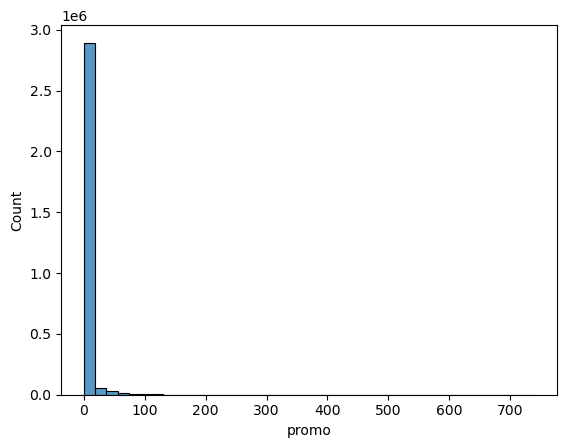

In [19]:
sns.histplot(df.promo, bins = 40)

In [20]:
transformed_promo = np.log1p(df['promo']) 

In [21]:
transformed_sales.describe().loc[['min', 'max']] 

min    0
max   11
Name: sales, dtype: float64

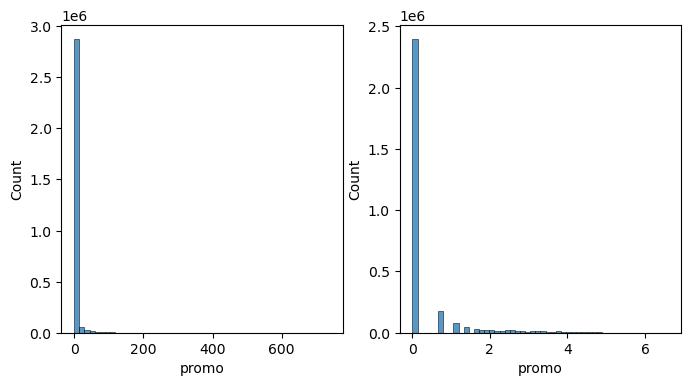

In [22]:
plt.figure(figsize = [8,4])

plt.subplot(1, 2, 1)
sns.histplot(df.promo, bins = 50)

plt.subplot(1, 2, 2)
sns.histplot(transformed_promo, bins = 50)

plt.show()

In [23]:
df['promo'] = transformed_promo

In [24]:
transformed_promo_test = np.log1p(df_test['promo']) 
transformed_promo_test.describe().loc[['min', 'max']] 

min   0
max   6
Name: promo, dtype: float64

In [25]:
df_test['promo'] = transformed_promo_test

### Creating cyclical time features <a id="cyclical"></a> 

Creating cyclical features for DateTime variables involves transforming the date or time information into a format that captures its cyclical nature. This is particularly useful for machine learning models, especially when dealing with periodic patterns like days of the week, months, or hours of the day. One common approach is to use sine and cosine transformations.

In [26]:
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs).drop(columns=[col_name])

We will pick weekdays and months for our trasformation. With days it is complicated by the fact that months have varying lengths. Not all months have the same number of days. Some have 28, 30, or 31 days, which creates inconsistency when handling the cyclical transformation. Thus we will not transform days.

In [27]:
df_feat_weekday = generate_cyclical_features(df, 'weekday', 6, 0)
df_final = generate_cyclical_features(df_feat_weekday, 'month', 12, 1)

In [28]:
df_final.head()

,store_nbr,sales,promo,oil_price,holiday,events,year,day,products_automotive,products_baby_care,products_beauty,products_beverages,products_books,products_bread/bakery,products_celebration,products_cleaning,products_dairy,products_deli,products_eggs,products_frozen_foods,products_grocery_i,products_grocery_ii,products_hardware,products_home_and_kitchen_i,products_home_and_kitchen_ii,products_home_appliances,products_home_care,products_ladieswear,products_lawn_and_garden,products_lingerie,"products_liquor,wine,beer",products_magazines,products_meats,products_personal_care,products_pet_supplies,products_players_and_electronics,products_poultry,products_prepared_foods,products_produce,products_school_and_office_supplies,products_seafood,city_ambato,city_babahoyo,city_cayambe,city_cuenca,city_daule,city_el_carmen,city_esmeraldas,city_guaranda,city_guayaquil,city_ibarra,city_latacunga,city_libertad,city_loja,city_machala,city_manta,city_playas,city_puyo,city_quevedo,city_quito,city_riobamba,city_salinas,city_santo_domingo,sin_weekday,cos_weekday,sin_month,cos_month
0,1,0,0,93,True,False,2013,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1
1,1,0,0,93,True,False,2013,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1
2,1,0,0,93,True,False,2013,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1
3,1,0,0,93,True,False,2013,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1
4,1,0,0,93,True,False,2013,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1


In [29]:
df_test_feat_weekday = generate_cyclical_features(df_test, 'weekday', 6, 0)
df_test_final = generate_cyclical_features(df_test_feat_weekday, 'month', 12, 1)

In [30]:
df_test_final.head()

,store_nbr,promo,oil_price,holiday,events,year,day,products_automotive,products_baby_care,products_beauty,products_beverages,products_books,products_bread/bakery,products_celebration,products_cleaning,products_dairy,products_deli,products_eggs,products_frozen_foods,products_grocery_i,products_grocery_ii,products_hardware,products_home_and_kitchen_i,products_home_and_kitchen_ii,products_home_appliances,products_home_care,products_ladieswear,products_lawn_and_garden,products_lingerie,"products_liquor,wine,beer",products_magazines,products_meats,products_personal_care,products_pet_supplies,products_players_and_electronics,products_poultry,products_prepared_foods,products_produce,products_school_and_office_supplies,products_seafood,city_ambato,city_babahoyo,city_cayambe,city_cuenca,city_daule,city_el_carmen,city_esmeraldas,city_guaranda,city_guayaquil,city_ibarra,city_latacunga,city_libertad,city_loja,city_machala,city_manta,city_playas,city_puyo,city_quevedo,city_quito,city_riobamba,city_salinas,city_santo_domingo,sin_weekday,cos_weekday,sin_month,cos_month
0,1,0,47,False,False,2017,16,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,-0,-0,-1
1,1,0,47,False,False,2017,16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,-0,-0,-1
2,1,1,47,False,False,2017,16,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,-0,-0,-1
3,1,3,47,False,False,2017,16,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,-0,-0,-1
4,1,0,47,False,False,2017,16,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,-0,-0,-1


### Setting up the validation framework <a id="validation"></a> 

Setting up the validation framework before scaling numerical features is advisable. If we scale the entire dataset before splitting it into training and validation sets, we will leak information from the validation set into the training set. This leakage can cause our model to perform artificially well during validation, but it won't generalize as well to unseen data.

In [31]:
y = df_final[['sales']]
X = df_final.drop(columns=['sales'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False, random_state=1)

In [32]:
# verifying results
print('X_train length', len(X_train))
print('X_val length', len(X_val))
print('y_train length', len(y_train))
print('y_val length', len(y_val))
print('X_test length', len(X_test))
print('y_test length', len(y_test))

X_train length 1804968
X_val length 601656
y_train length 1804968
y_val length 601656
X_test length 601656
y_test length 601656


### Selecting features <a id="features"></a> 

Statistical tests like the F-statistic are used to determine whether there are statistically significant relationships between features and the target variable.
We can apply F-statistic-based feature selection to identify the most relevant features for a regression task.

The F-statistic measures how well each feature explains the variance in the target variable and is commonly used in regression to assess whether there is a statistically significant linear relationship between each feature and the target.

Features with p-values below 0.05 are considered important, as this threshold provides strong evidence that these features are related to the target variable and should be kept for further modeling.

In [33]:
# performing F-statistic based feature selection
f_values, p_values = f_regression(X_train, y_train)
selected_features = X_train.columns[p_values < 0.05]

In [34]:
X_train_selected = X_train[selected_features]  
X_val_selected = X_val[selected_features]
X_test_selected = X_test[selected_features]
df_test_selected = df_test_final[selected_features]      

In [35]:
print(selected_features)

Index(['store_nbr', 'promo', 'oil_price', 'holiday', 'events', 'year', 'day',
       'products_automotive', 'products_baby_care', 'products_beauty',
       'products_beverages', 'products_books', 'products_bread/bakery',
       'products_celebration', 'products_cleaning', 'products_dairy',
       'products_deli', 'products_eggs', 'products_frozen_foods',
       'products_grocery_i', 'products_grocery_ii', 'products_hardware',
       'products_home_and_kitchen_i', 'products_home_and_kitchen_ii',
       'products_home_appliances', 'products_home_care', 'products_ladieswear',
       'products_lawn_and_garden', 'products_lingerie',
       'products_liquor,wine,beer', 'products_magazines', 'products_meats',
       'products_personal_care', 'products_pet_supplies',
       'products_players_and_electronics', 'products_poultry',
       'products_prepared_foods', 'products_produce',
       'products_school_and_office_supplies', 'products_seafood',
       'city_ambato', 'city_babahoyo', 'city_ca

### Scaling Numerical Features <a id="numerical"></a> 

After selecting the most important features using mutual_info_regression, we can proceed with scaling the numerical features. Fitting StandardScaler on the training data, and then apply the scaling to both the training and validation sets. Fitting the scaler on the training data only ensures that the model only learns from the training data and not from the validation or test data, which helps to avoid data leakage.

Scaling after feature selection ensures you only scale the features you are going to use, which reduces the risk of introducing unnecessary transformations.

In [36]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)
X_test_scaled = scaler.transform(X_test_selected)
df_test_scaled = scaler.transform(df_test_selected)

### Choosing the model <a id="model"></a> 

There are several models available for time series tasks, but LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit) are specifically designed for this type of work.

LSTMs are great for handling long-term relationships in time series data, making them ideal for complex tasks where patterns stretch over long periods. They are particularly accurate for time series with non-linear trends and seasonality. LSTMs often outperform simpler models when dealing with complicated data. However, they are also computationally demanding because they require more time and resources (such as GPUs) due to their large number of parameters and the way they process data in sequences. Additionally, LSTMs are considered black-box models, meaning they are hard to understand, and it’s difficult to see exactly how they make predictions.

GRUs are similar to LSTMs but have a simpler design. They also capture long-term patterns but are generally faster to train and sometimes slightly less powerful. For many tasks, GRUs give results similar to LSTMs, especially when the time series doesn’t rely too heavily on long-term dependencies. GRUs are more efficient than LSTMs because they have fewer parameters, making them quicker to train and requiring fewer resources. This makes them better for large datasets or real-time applications. Like LSTMs, GRUs are also black-box models, so they are still hard to interpret and understand.

It is worth mentioning that LSTM and GRU are both types of recurrent neural network (RNN) architectures designed to address the vanishing gradient problem in traditional RNNs, allowing them to capture long-term dependencies in sequential data.

GRU strikes a good balance between accuracy and efficiency. It handles complex time series well but is faster and easier to train than LSTM.

Based on these factors, I decided to use both GRU and LSTM models and compare their performances. 

In [57]:
X_train_scaled = X_train_scaled.astype(np.float32)
X_val_scaled = X_val_scaled.astype(np.float32)
X_test_scaled = X_test_scaled.astype(np.float32)

A generator is used to load data in smaller chunks (batches) rather than all at once, which is useful when working with large datasets. It prepares small chunks of data (batches) for training, where each chunk contains sequences of a certain number of time steps. It continuously provides the model with fresh batches of data during training, which helps manage large datasets efficiently without loading everything into memory at once.

In [186]:
def data_generator(X, y, time_steps, batch_size):
    while True:
        # looping over the dataset in batches
        for i in range(0, len(X) - time_steps, batch_size):
            X_batch = []
            y_batch = []
            
            # for each batch, creating time steps
            for j in range(batch_size):
                if i + j + time_steps < len(X):
                    
                    X_batch.append(X[i + j:i + j + time_steps])
                    
                    # boundary check for y
                    if i + j + time_steps < len(y):
                        y_batch.append(y.iloc[i + j + time_steps])
                    else:
                        print(f"Index out of bounds for y: {i + j + time_steps}")

            # yield the batch
            yield np.array(X_batch), np.array(y_batch)

BATCH_SIZE = 1024
TIME_STEPS = 30

train_gen = data_generator(X_train_scaled, y_train, TIME_STEPS, BATCH_SIZE)
val_gen = data_generator(X_val_scaled, y_val, TIME_STEPS, BATCH_SIZE)

# checking sample outputs
X_batch_sample, y_batch_sample = next(train_gen)
print(f"Sample X_batch shape: {X_batch_sample.shape}")
print(f"Sample y_batch shape: {y_batch_sample.shape}")


Sample X_batch shape: (1024, 30, 66)
Sample y_batch shape: (1024, 1)


The function create_model builds a time series model using either LSTM or GRU layers. These layers are good at learning patterns over sequences of time steps, which is important for time series prediction. 

The model has two layers of LSTM/GRU with dropout to prevent overfitting, and the final layer predicts a single value.

The model is compiled with MSE as the loss function and Adam as the optimizer, which helps it learn during training.

In [187]:
def create_model(units, m, time_steps, num_features):
    model = Sequential() 
    # First layer of LSTM/GRU
    model.add(m(units=units, return_sequences=True, input_shape=(time_steps, num_features)))
    model.add(Dropout(0.2)) 
    # Second layer of LSTM/GRU
    model.add(m(units=units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units=1)) 
    
    model.compile(loss='mse', optimizer='adam')
    return model


num_features = X_train_scaled.shape[1]  


model_gru = create_model(64, GRU, TIME_STEPS, num_features)
model_lstm = create_model(64, LSTM, TIME_STEPS, num_features)


Verifying the output of the data generator for debugging purposes. 

In [192]:

def check_data_generator(generator, batch_size):
    X_batch, y_batch = next(generator)
    print(f"Batch X shape: {X_batch.shape}")
    print(f"Batch y shape: {y_batch.shape}")
    print(f"Number of samples in one batch (X): {X_batch.shape[0]}")
    print(f"Number of features in one sample (X): {X_batch.shape[2]}")
    print(f"Number of samples in one batch (y): {y_batch.shape[0]}")

# checking a batch from the train generator
check_data_generator(train_gen, BATCH_SIZE)

# checking a batch from the validation generator
check_data_generator(val_gen, BATCH_SIZE)


Batch X shape: (1024, 30, 66)
Batch y shape: (1024, 1)
Number of samples in one batch (X): 1024
Number of features in one sample (X): 66
Number of samples in one batch (y): 1024
Batch X shape: (1024, 30, 66)
Batch y shape: (1024, 1)
Number of samples in one batch (X): 1024
Number of features in one sample (X): 66
Number of samples in one batch (y): 1024


### Fitting model <a id="fitting"></a> 

The fit_model function trains our LSTM or GRU model on our time series data. It uses early stopping to stop training if validation loss doesn't improve after 10 epochs.

Training and validation data are fed in batches using generators. 

In [193]:

def fit_model(model, train_gen, val_gen, steps_per_epoch, validation_steps):
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    
    
    history = model.fit(
        train_gen,
        epochs=10,
        validation_data=val_gen,
        steps_per_epoch=steps_per_epoch,          
        validation_steps=validation_steps,        
        callbacks=[early_stop],
        shuffle=False                             
    )
    return history


BATCH_SIZE = 1024
steps_per_epoch = len(X_train_scaled) // BATCH_SIZE
validation_steps = len(X_val_scaled) // BATCH_SIZE


history_lstm = fit_model(model_lstm, train_gen, val_gen, steps_per_epoch, validation_steps)
history_gru = fit_model(model_gru, train_gen, val_gen, steps_per_epoch, validation_steps)


Epoch 1/10
1762/1762 [==============================] - 703s 395ms/step - loss: 1.2632 - val_loss: 0.8979
Epoch 2/10
1762/1762 [==============================] - 690s 391ms/step - loss: 0.7570 - val_loss: 0.8264
Epoch 3/10
1762/1762 [==============================] - 691s 392ms/step - loss: 0.7081 - val_loss: 0.7772
Epoch 4/10
1762/1762 [==============================] - 1473s 836ms/step - loss: 0.6615 - val_loss: 0.7995
Epoch 5/10
1762/1762 [==============================] - 791s 449ms/step - loss: 0.6532 - val_loss: 0.8245
Epoch 6/10
1762/1762 [==============================] - 792s 450ms/step - loss: 0.6177 - val_loss: 0.8250
Epoch 7/10
1762/1762 [==============================] - 778s 442ms/step - loss: 0.6185 - val_loss: 0.8403
Epoch 8/10
1762/1762 [==============================] - 674s 382ms/step - loss: 0.5942 - val_loss: 0.8712
Epoch 9/10
1762/1762 [==============================] - 715s 406ms/step - loss: 0.5885 - val_loss: 0.9349
Epoch 10/10
1762/1762 [======================

Let's visualize the results

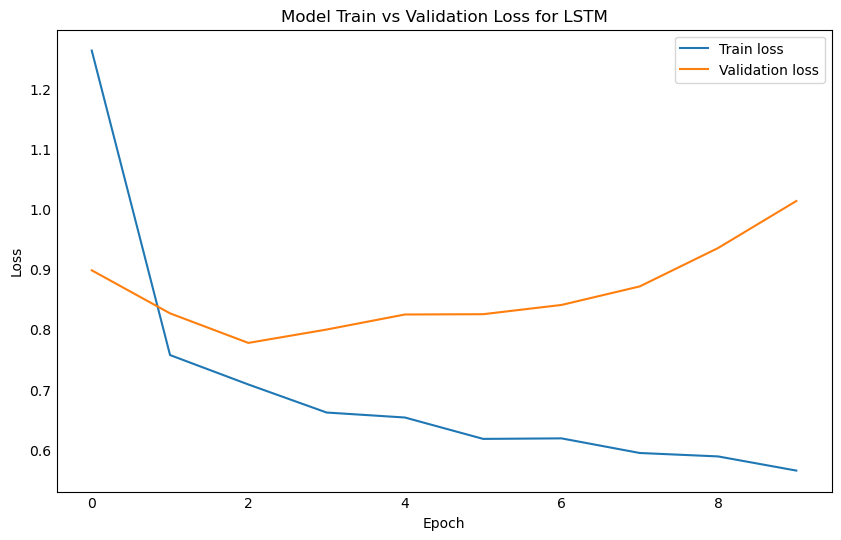

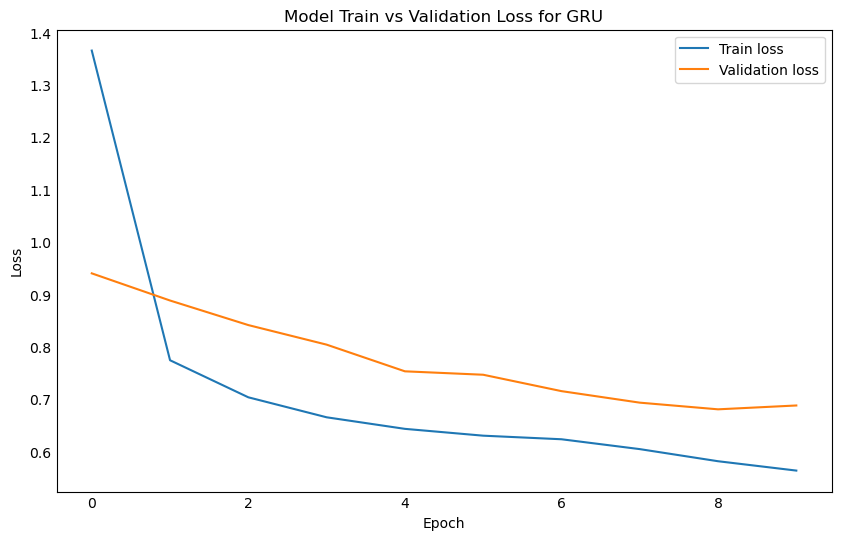

In [194]:
def plot_loss(history, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title(f'Model Train vs Validation Loss for {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    
    ax = plt.gca()
    ax.xaxis.set_tick_params(length=0)  
    ax.yaxis.set_tick_params(length=0)  

    plt.show()

plot_loss(history_lstm, 'LSTM')
plot_loss(history_gru, 'GRU')



#### LSTM performance
Train loss decreases steadily throughout the training, indicating the model is continuing to learn from the training data.
Validation loss, however, starts to increase after around 3 epochs, which is a clear sign of overfitting. 
The model starts to perform worse on unseen data even though it improves on the training data. To address we can:
- apply regularization techniques to help preventing overfitting
- we could also experiment with adjusting the model complexity (number of layers or units)

#### GRU performance

Train loss is steadily decreasing, which is a good sign that the model is learning. Validation loss also decreases steadily for the first several epochs and then plateaus around epoch 7-8, without showing signs of increasing or diverging. This suggests that the GRU model may be generalizing better than the LSTM model on validation data. While the validation loss stops improving significantly after epoch 7, it does not show the clear signs of overfitting like the LSTM.

In order to further reduce the validation loss, we can try hyperparameter tuning (e.g., adjusting learning rate, batch size, or model architecture).
Overall, the GRU model seems to be performing better than the LSTM in this case.

In [195]:
# inversing transformation for y_values
y_train = np.expm1(y_train)
y_val = np.expm1(y_val)
y_test = np.expm1(y_test)

Creating amended verion of data_generator for the test sets not containg y values. 

In [218]:
def data_generator_test(X_data, timesteps, batch_size):
    while True:
        for i in range(0, len(X_data) - timesteps, batch_size):
            X_batch = np.array([X_data[j:j+timesteps] for j in range(i, min(i+batch_size, len(X_data) - timesteps))])
            yield X_batch

batch_size = 1024
steps_per_epoch = len(X_test_scaled) // BATCH_SIZE
test_data_generator = data_generator(X_test_scaled, y_test, steps_per_epoch, batch_size)

In [220]:
TIME_STEPS = 30 
batch_size = 1024  

df_test = data_generator_test(df_test_scaled, TIME_STEPS, batch_size)


Using both models for predictions

In [224]:
def prediction(model):
    prediction = model.predict(df_test)
       
    return prediction

prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)


An earlier experimental model was used to test the fitting of the test set for prediction. Results are below.

30/30 [==============================] - 0s 10ms/step


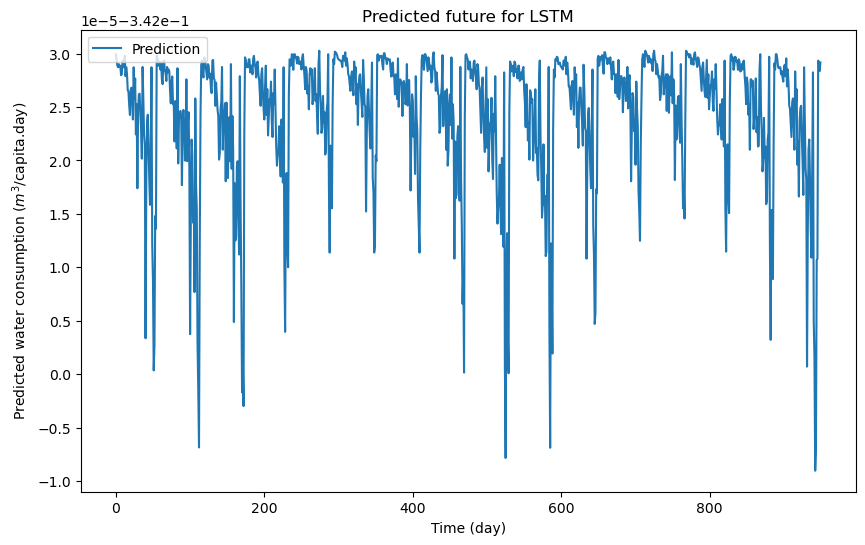

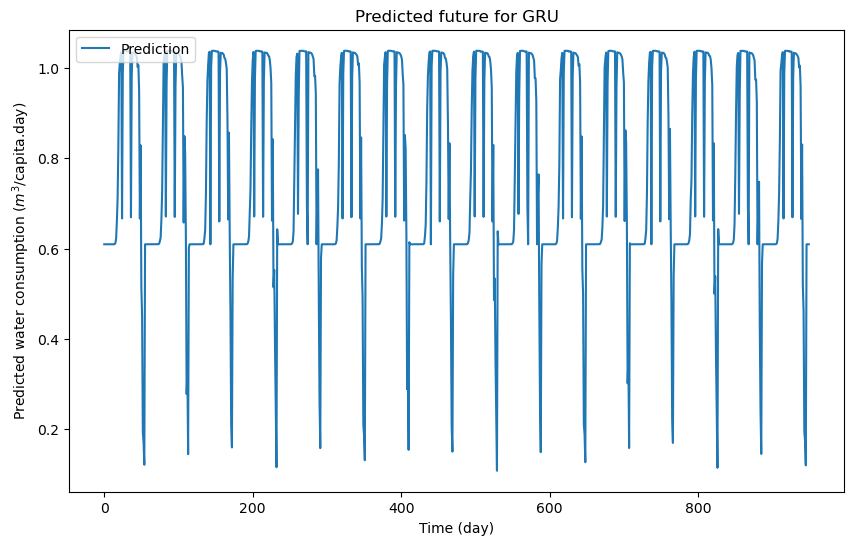

In [ ]:
def plot_future(prediction, model_name):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(prediction), label='Prediction')

    plt.title('Predicted future for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Predicted Sales)')
   


def prediction(model):
    prediction = model.predict(X_test_reshaped)
    
    prediction = np.expm1(prediction)  
    
    return prediction

prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)


plot_future(prediction_lstm, 'LSTM')
plot_future(prediction_gru, 'GRU')


In [ ]:
def evaluate_prediction(predictions, model_name):
    
    print(model_name + ' predictions stats:')
    print('Mean of Predictions: {:.4f}'.format(np.mean(predictions)))
    print('Standard Deviation of Predictions: {:.4f}'.format(np.std(predictions)))
    print('Minimum of Predictions: {:.4f}'.format(np.min(predictions)))
    print('Maximum of Predictions: {:.4f}'.format(np.max(predictions)))
    print('')



evaluate_prediction(prediction_lstm, 'LSTM')
evaluate_prediction(prediction_gru, 'GRU')


LSTM predictions stats:
Mean of Predictions: -0.3420
Standard Deviation of Predictions: 0.0000
Minimum of Predictions: -0.3420
Maximum of Predictions: -0.3420

GRU predictions stats:
Mean of Predictions: 0.7808
Standard Deviation of Predictions: 0.2320
Minimum of Predictions: 0.1081
Maximum of Predictions: 1.0385



LSTM Predictions:
Identical Predictions: All predictions from the LSTM are exactly the same, with a value of -0.3420.

GRU Predictions:
Variance in Predictions: The GRU model produces varied predictions with a mean of 0.7808, a minimum of 0.1081, and a maximum of 1.0385, suggesting the model is making different predictions for different data points.

Comparing LSTM and GRU Predictions on New Data:
LSTM: The uniform predictions from the LSTM suggest that it is not generalizing to new data. There might be a significant mismatch between how the model was trained and the new data it’s being asked to predict on.

GRU: The GRU, on the other hand, appears to be generalizing better and responding to new data more effectively. Its varied predictions suggest that it has learned useful patterns and is applying them to the new dataset.

### The baseline model <a id="baseline"></a> 

The ARIMA (AutoRegressive Integrated Moving Average) model is a popular statistical model used for time series forecasting. It is often used as a baseline because it provides a simple yet effective way to forecast time series data. 

By establishing ARIMA as a baseline, we can assess whether more sophisticated models, such as LSTM or GRU, offer a significant improvement over this simple approach. If the complex models don’t perform substantially better than ARIMA, it might indicate issues with feature engineering or model tuning.



In [ ]:
train_size = int(len(df) * 0.7)
train, test = df['sales'][:train_size], df['sales'][train_size:]

model = ARIMA(train, order=(5, 1, 0))  
model_fit = model.fit(disp=0)

forecast = model_fit.forecast(steps=len(test))[0]

mse = mean_squared_error(test, forecast)
print(f'Mean Squared Error: {mse}')


### Results and findings <a id="results"></a> 


In regard to model training and test set prediction, below is a list of the anticipated steps and their respective outcomes:

- Split all preprocessed data into train (60%), validation (20%), and test (20%) sets – accomplished.

- Select and train LSTM and GRU models on the train and validation sets – accomplished.

- Test both models on the test set and compare performance – this step took unexpectedly long (over 8 hours), far longer than anticipated. There was insufficient time to investigate and resolve potential issues. The models spent all night predicting on the test set but did not complete on time. Potential solutions worth investigating include simplifying the model by reducing the number of GRU units or layers, optimizing the data generator, adjusting batch sizes, or switching to cloud-based GPU for prediction.

- Use the best model on the test set provided – unaccomplished due to lack of time before the deadline.

- Use the ARIMA model as a benchmark – unaccomplished for the same reason as above.

More time is required to fully test and evaluate the models' performance.

#### GRU and LSTM models performance observations.

The GRU and LSTM models, while effective for sequential data, can be resource-intensive, requiring significant computational power and time for training. Limitations in hardware and time constraints led me to suboptimal performance and longer training times. To improve performance, fine-tuning model parameters such as batch size, learning rate, and the number of layers can help optimize resource usage and potentially yield better results. Regularization techniques and early stopping can also enhance efficiency and model performance.

When discussing the performance of LSTM and GRU models, it's important to consider the balance between accuracy and efficiency. LSTMs are known for their accuracy in capturing long-term dependencies in sequential data, but they tend to be more computationally expensive due to their complex architecture. GRUs, on the other hand, are more efficient because they have a simpler structure, often requiring less computational power and training time. However, GRUs might slightly sacrifice accuracy in capturing long-range dependencies compared to LSTMs.

In scenarios with limited resources, GRUs offer a practical trade-off between accuracy and efficiency, while LSTMs might be preferable if long-term accuracy is critical and resources allow.

To further improve model training, Time Series K-Fold cross-validation can be used to better evaluate and optimize the model on sequential data, ensuring more robust performance across time-based splits.